In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Dense, Flatten, Dropout, SeparableConv1D
import matplotlib.pyplot as plt
import seaborn as sns


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
diagnosis_df = pd.read_csv('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['Patient number', 'Diagnosis'])
diagnosis_df.head(4)

,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


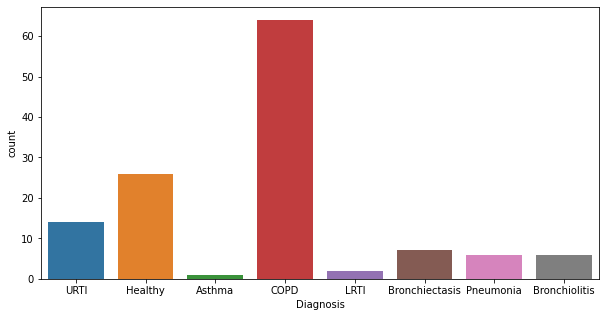

In [3]:
plt.figure(figsize=(10,5))
sns.countplot(diagnosis_df['Diagnosis'])

In [4]:
df_no_diagnosis = pd.read_csv('../input/respiratory-sound-database/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')
df_no_diagnosis.head(5)

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [5]:
df =  df_no_diagnosis.join(diagnosis_df.set_index('Patient number'), on = 'Patient number', how = 'left')
df.head(10)

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI
5,106,73.00,F,21.00,NaN,NaN,COPD
6,107,75.00,F,33.70,NaN,NaN,COPD
7,108,3.00,M,NaN,NaN,NaN,LRTI
8,109,84.00,F,33.53,NaN,NaN,COPD
9,110,75.00,M,25.21,NaN,NaN,COPD


In [6]:
root = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,156,8b3,Lr,mc,AKGC417L
0,193,7b3,Ar,mc,AKGC417L
0,130,1p2,Ll,mc,AKGC417L
0,160,1b2,Pl,mc,AKGC417L
0,211,1p3,Ar,mc,AKGC417L


In [7]:
class Diagnosis():
    def __init__ (self, id, diagnosis, image_path):
        self.id = id
        self.diagnosis = diagnosis 
        self.image_path = image_path   

In [8]:
def get_wav_files():
    audio_path = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
    files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
    wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files 
    wav_files = sorted(wav_files)
    return wav_files, audio_path

In [9]:
def diagnosis_data():
    diagnosis = pd.read_csv('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv')
  
    wav_files, audio_path = get_wav_files()
    diag_dict = { 101 : "URTI"}  
    diagnosis_list = []
  
    for index , row in diagnosis.iterrows():
        diag_dict[row[0]] = row[1]     

    c = 0
    for f in wav_files:
        diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))  
        c+=1  

    return diagnosis_list

In [10]:
import librosa
import librosa.display

def audio_features(filename): 
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound))  
 
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    
    concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
    return concat

def data_points():
    labels = []
    images = []

    to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

    #count = 0
    for f in diagnosis_data():
        #print(count)
        labels.append(to_hot_one[f.diagnosis]) 
        images.append(audio_features(f.image_path))
        #count+=1

    return np.array(labels), np.array(images)

# DataFrame for Diagnosis and audio

In [11]:
path = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/filename_differences.txt'

diff = pd.read_csv(path, sep=" ", header=None, names=['file_names'])
diff.head(5)

,file_names
0,'101_1b1_Al_sc_AKGC417L'
1,'101_1b1_Pr_sc_AKGC417L'
2,'102_1b1_Ar_sc_AKGC417L'
3,'105_1b1_Tc_sc_LittC2SE'
4,'108_1b1_Al_sc_LittC2SE'


In [12]:
df =  diff.join(diagnosis_df,how = 'left')
df.head(15)

,file_names,Patient number,Diagnosis
0,'101_1b1_Al_sc_AKGC417L',101,URTI
1,'101_1b1_Pr_sc_AKGC417L',102,Healthy
2,'102_1b1_Ar_sc_AKGC417L',103,Asthma
3,'105_1b1_Tc_sc_LittC2SE',104,COPD
4,'108_1b1_Al_sc_LittC2SE',105,URTI
5,'111_1b2_Tc_sc_LittC2SE',106,COPD
6,'111_1b3_Tc_sc_LittC2SE',107,COPD
7,'115_1b1_Ar_sc_LittC2SE',108,LRTI
8,'116_1b2_Pl_sc_LittC2SE',109,COPD
9,'116_1b2_Tc_sc_LittC2SE',110,COPD


# Mel spectrograms and MFCCs

In [13]:
x = audio_features('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav')
S = librosa.feature.melspectrogram(x)

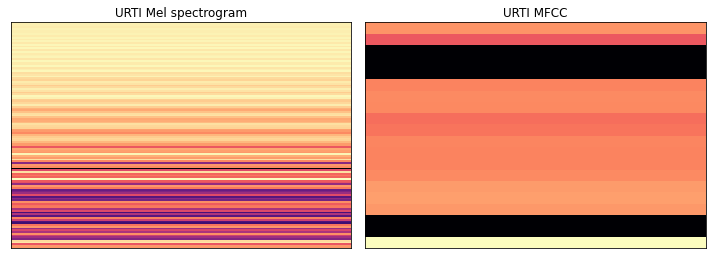

In [14]:
plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title('URTI Mel spectrogram')
plt.tight_layout()

T = librosa.feature.mfcc(x)
plt.subplot(2,2,2)
librosa.display.specshow(librosa.power_to_db(T, ref=np.max))
plt.title('URTI MFCC')
plt.tight_layout()

# COPD Mel Spectrograms and MFCCs

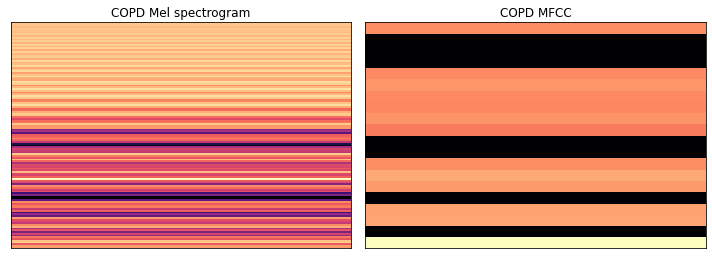

In [15]:
x1 = audio_features('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_Litt3200.wav')
S1 = librosa.feature.melspectrogram(x1)

plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
librosa.display.specshow(librosa.power_to_db(S1, ref=np.max))
plt.title('COPD Mel spectrogram')
plt.tight_layout()

T1 = librosa.feature.mfcc(x1)
plt.subplot(2,2,2)
librosa.display.specshow(librosa.power_to_db(T1, ref=np.max))
plt.title('COPD MFCC')
plt.tight_layout()

# Healthy Mel Spectrogram and MFCCs

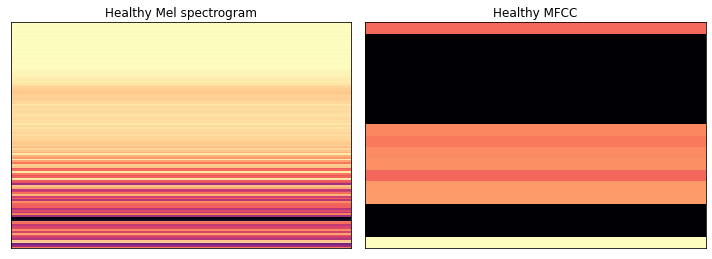

In [16]:
x2 = audio_features('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav')
S2 = librosa.feature.melspectrogram(x2)

plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
librosa.display.specshow(librosa.power_to_db(S2, ref=np.max))
plt.title('Healthy Mel spectrogram')
plt.tight_layout()

T2 = librosa.feature.mfcc(x2)
plt.subplot(2,2,2)
librosa.display.specshow(librosa.power_to_db(T2, ref=np.max))
plt.title('Healthy MFCC')
plt.tight_layout()

In [17]:
from sklearn.model_selection import train_test_split

def preprocessing(labels, images):    

  # Remove Asthma and LRTI
    images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
    labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      

  # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)  

  # Format new data
    y_train = np.reshape(y_train, (y_train.shape[0], 6))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 6))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

    return X_train, X_test, y_train, y_test

In [18]:
from os import listdir
from os.path import isfile, join
from tensorflow.keras.utils import plot_model,to_categorical

labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


# Depthwise Separable CNN model

In [19]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=200, verbose=1)

Epoch 1/70
4/4 [==============================] - 1s 148ms/step - loss: 1.2470 - accuracy: 0.6289 - val_loss: 0.4990 - val_accuracy: 0.8967
Epoch 2/70
4/4 [==============================] - 0s 22ms/step - loss: 0.7281 - accuracy: 0.8568 - val_loss: 0.4726 - val_accuracy: 0.8967
Epoch 3/70
4/4 [==============================] - 0s 22ms/step - loss: 0.7045 - accuracy: 0.8568 - val_loss: 0.4250 - val_accuracy: 0.8967
Epoch 4/70
4/4 [==============================] - 0s 19ms/step - loss: 0.5834 - accuracy: 0.8568 - val_loss: 0.4642 - val_accuracy: 0.8967
Epoch 5/70
4/4 [==============================] - 0s 26ms/step - loss: 0.5735 - accuracy: 0.8568 - val_loss: 0.4370 - val_accuracy: 0.8967
Epoch 6/70
4/4 [==============================] - 0s 26ms/step - loss: 0.5505 - accuracy: 0.8568 - val_loss: 0.4175 - val_accuracy: 0.8967
Epoch 7/70
4/4 [==============================] - 0s 21ms/step - loss: 0.5529 - accuracy: 0.8568 - val_loss: 0.4123 - val_accuracy: 0.8967
Epoch 8/70
4/4 [==========

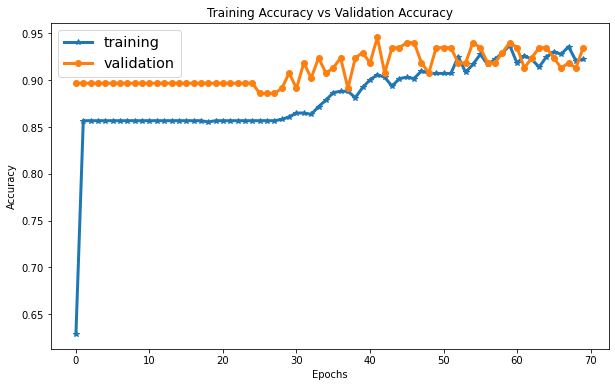

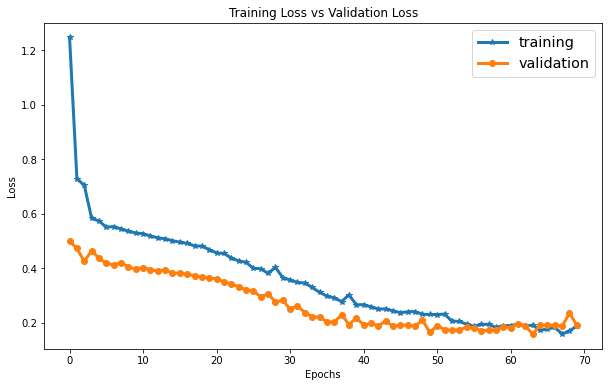

In [20]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

# Model Confusion Matrix

                precision    recall  f1-score   support

          COPD       0.99      0.98      0.98       165
       Healthy       0.56      0.71      0.63         7
          URTI       0.00      0.00      0.00         4
Bronchiectasis       1.00      0.75      0.86         4
     Pneumoina       0.38      1.00      0.55         3
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.93       184
     macro avg       0.49      0.57      0.50       184
  weighted avg       0.93      0.93      0.93       184



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


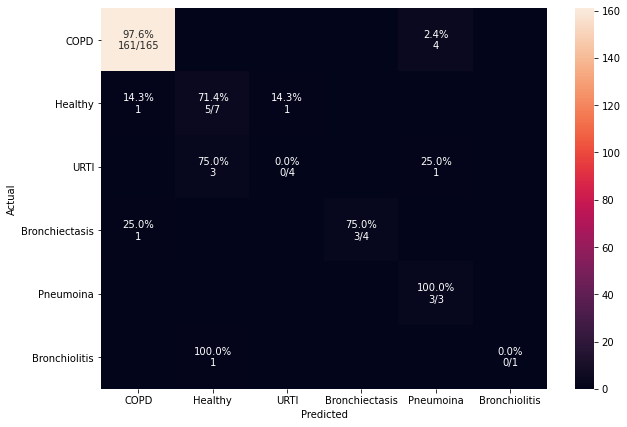

In [21]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

# Model Architecture

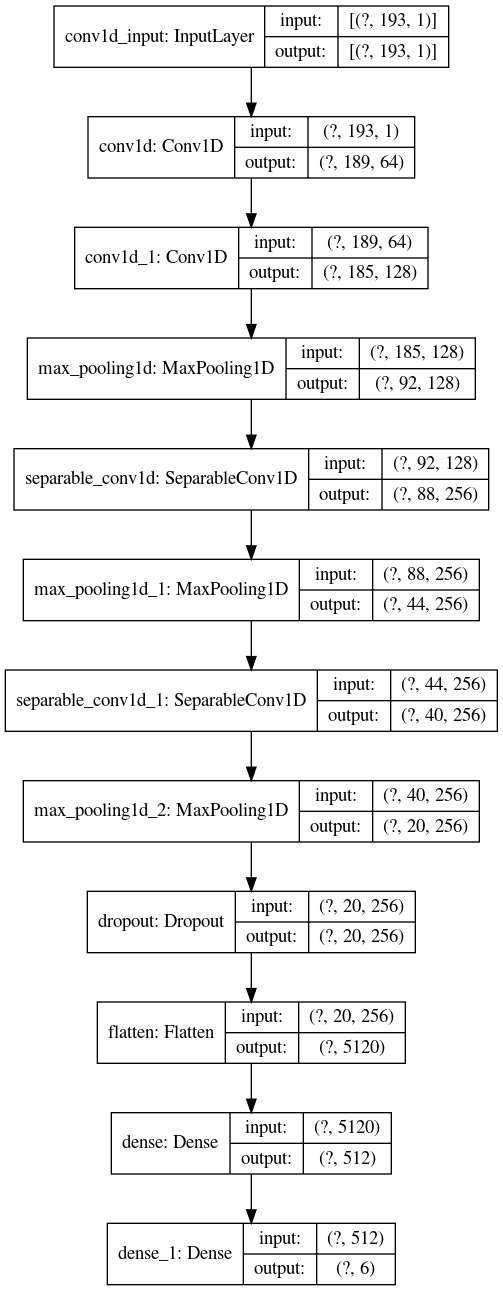

In [22]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)